In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline
torch.manual_seed(0)
np.random.seed(0)

In [3]:
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

In [4]:
print(len(train_dataset), len(test_dataset))
print(train_dataset.train_data.size())

60000 10000
torch.Size([60000, 28, 28])


In [5]:
sample_x, sample_y = train_dataset[0][0], train_dataset[0][1]

tensor(5)


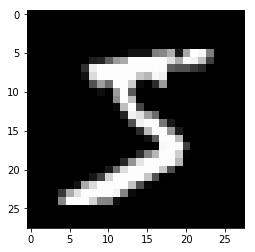

In [6]:
plt.imshow(sample_x.numpy().reshape(28,28), cmap='gray')
print(sample_y)

In [7]:
batch_size = 128
n_iter = 5000
n_epochs = n_iter/(len(train_dataset)/batch_size)
n_epochs = int(n_epochs)
print(n_epochs)

10


In [8]:
train_loader = data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = data.DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

In [9]:
class ConvModel(nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()
        # conv2d args: in_channels, out_channels, kernel_size, stride, padding
        self.conv1 = nn.Conv2d(1, 16, 5, 1, 2)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
        self.batchnorm2 = nn.BatchNorm2d(32)

        self.maxpool = nn.MaxPool2d(2)
        
        self.fc1 = nn.Linear(32*14*14, 100)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(100, 10)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        
        out = self.maxpool(out)
        
        # Flatten
        out = out.view(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.relu(out)
        # read out
        out = self.fc2(out)
        return out

In [10]:
model = ConvModel()

In [11]:
criterion = nn.CrossEntropyLoss()

In [12]:
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [13]:
print(model.parameters())
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

<generator object Module.parameters at 0x7f52a3dd0eb8>
12
torch.Size([16, 1, 5, 5])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([100, 6272])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])


In [14]:
counter = 0
train_loss = []
for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images)
        labels = Variable(labels)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        train_loss.append(loss.data)
        
        loss.backward()
        
        optimizer.step()
        
        # evaluation
        if counter%500 == 0:
            total = 0
            correct = 0
            
            for images, labels in test_loader:
                images = Variable(images)
                labels = Variable(labels)
                
                pred = model(images)
                _, pred = torch.max(pred.data, 1)
                
                correct += (pred == labels).sum()
                total += labels.size(0)
            accuracy = 100 * (correct.numpy()/total)
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(counter, loss.data, accuracy))
        counter += 1

Iteration: 0. Loss: 2.295896053314209. Accuracy: 17.48
Iteration: 500. Loss: 0.13481611013412476. Accuracy: 95.37
Iteration: 1000. Loss: 0.12210842967033386. Accuracy: 97.11999999999999
Iteration: 1500. Loss: 0.06443889439105988. Accuracy: 97.84
Iteration: 2000. Loss: 0.03986066207289696. Accuracy: 98.03
Iteration: 2500. Loss: 0.043821923434734344. Accuracy: 98.1
Iteration: 3000. Loss: 0.035847753286361694. Accuracy: 98.42999999999999
Iteration: 3500. Loss: 0.06401435285806656. Accuracy: 98.5
Iteration: 4000. Loss: 0.04516815394163132. Accuracy: 98.45
Iteration: 4500. Loss: 0.08645253628492355. Accuracy: 98.63


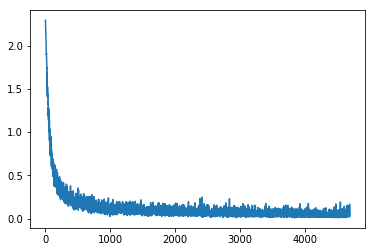

In [15]:
plt.plot(train_loss)

In [16]:
print(model)

ConvModel(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=100, bias=True)
  (dropout): Dropout(p=0.3)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)
